<div class='bar_title'></div>

*Data Driven Decisions in Practice (D3IP): Urban Analytics*

# Case Study: Predicting AirBnB Accomodation Prices

Gunther Gust & Nikolai Stein

Data Driven Decisions (D3) Group <br>
Center for Artificial Intelligence & Data Science <br>



<img src="images/d3.png" style="width:20%; float:left;" />

<img src="images/CAIDASlogo.png" style="width:20%; float:left;" />

Complete the case study outlined by the steps below. Remember to always comment your code and document your findings so that your notebook is easy to read and follow! (Apart from correctness, the style of the notebook will also affect your grade!)



# PART 1: Data Loading and Exploratory Data Analysis

Insructions:

* Load the `airbnb.geojson` file into this notebook as a geodataframe
* Explore the content of each column of the geodataframe using methods of your choice (descriptive statistics, plots etc.). Describe your findings in the markdown cells.
* Create a plot that displays the location of the airbnb listings and the price. Add a basemap of San Diego to the plot.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt 
import seaborn as sns
import contextily as cx

In [7]:
db = gpd.read_file("airbnb_listings.geojson")

db

,accommodates,bathrooms,bedrooms,beds,rt_Private_room,rt_Shared_room,pg_Condominium,pg_House,pg_Other,pg_Townhouse,price,geometry
0,5,2.0,2.0,2.0,0,0,0,1,0,0,425.0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,0,0,1,0,0,0,205.0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,1,0,0,0,0,0,99.0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,1,0,0,1,0,0,72.0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,1,0,0,1,0,0,55.0,POINT (-117.21870 32.74202)
...,...,...,...,...,...,...,...,...,...,...,...,...
6105,2,1.0,1.0,1.0,1,0,0,0,0,0,79.0,POINT (-117.21635 32.87142)
6106,6,2.0,2.0,2.0,0,0,1,0,0,0,295.0,POINT (-117.16342 32.71036)
6107,1,1.0,1.0,1.0,1,0,0,1,0,0,65.0,POINT (-117.12986 32.74252)
6108,3,1.0,1.0,1.0,0,0,0,0,0,0,170.0,POINT (-117.15070 32.71322)


<Axes: xlabel='accommodates', ylabel='Count'>

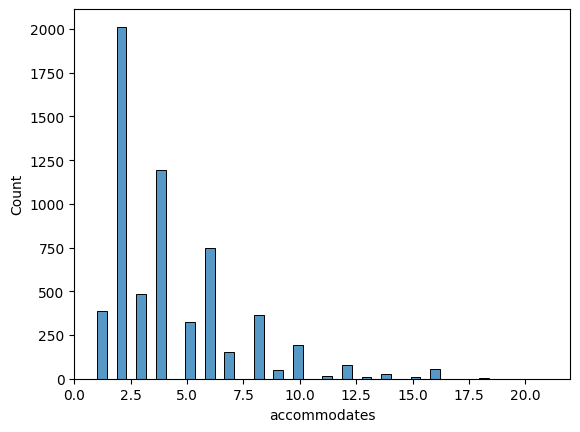

In [11]:
sns.histplot(db["accommodates"])

Most Airbnbs listed, are designed for 2-4 people.

<Axes: xlabel='bathrooms', ylabel='Count'>

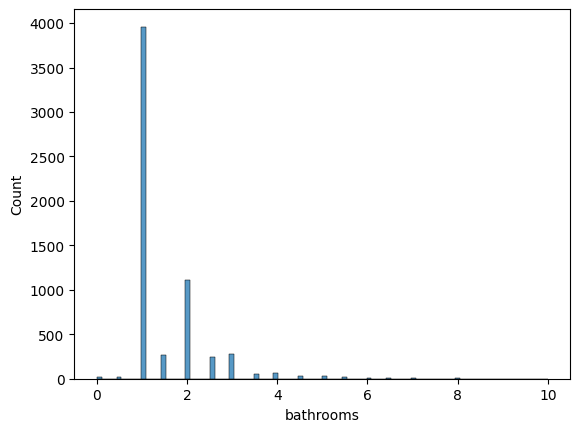

In [12]:
sns.histplot(db["bathrooms"])

Most of the listed Airbnbs have 1-2 bathrooms.

<Axes: xlabel='bedrooms', ylabel='Count'>

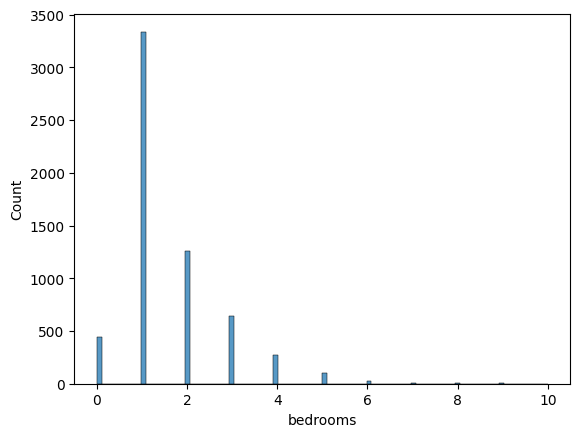

In [13]:
sns.histplot(db["bedrooms"])

Most listed Airbnbs have around 1-2 bedrooms.

<Axes: xlabel='beds', ylabel='Count'>

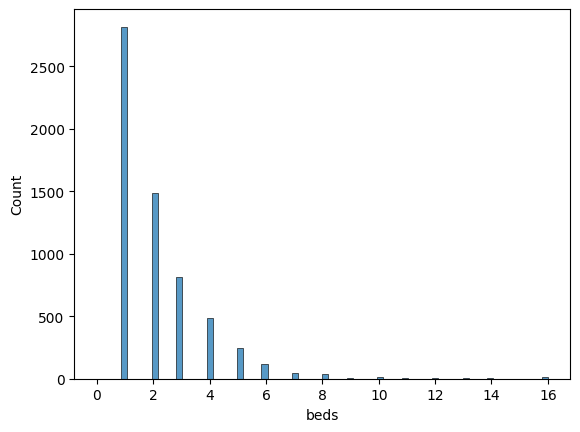

In [14]:
sns.histplot(db["beds"])

Most Airbnbs have around 1-2 beds.
==> In conclusion, most Airbnbs are designed to accommodate single people or small groups of around 2-6 people.

<Axes: xlabel='rt_Private_room', ylabel='Count'>

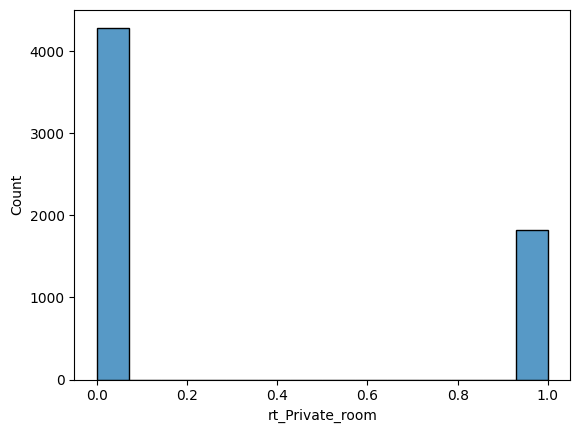

In [16]:
sns.histplot(db["rt_Private_room"])

About one third of the Airbnbs have Private rooms.

<Axes: xlabel='rt_Shared_room', ylabel='Count'>

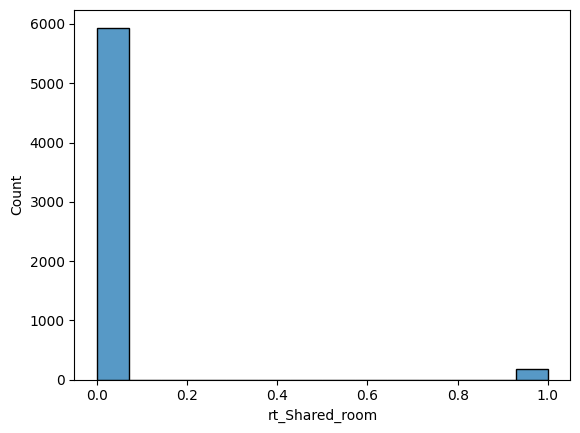

In [17]:
sns.histplot(db["rt_Shared_room"])

Only a small percent of Airbnbs have shared rooms.

<Axes: xlabel='pg_Condominium', ylabel='Count'>

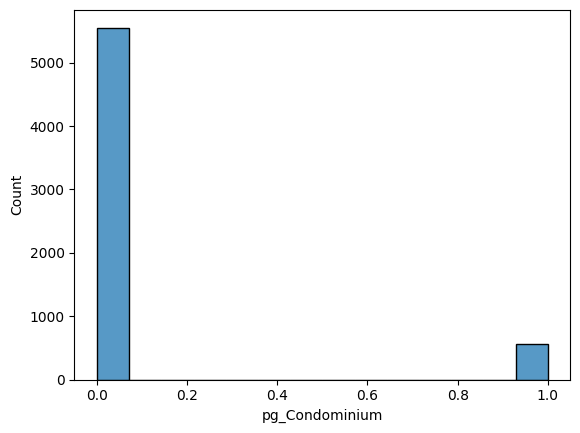

In [18]:
sns.histplot(db["pg_Condominium"])

Only a few of the listed Airbnbs are condos.

<Axes: xlabel='pg_House', ylabel='Count'>

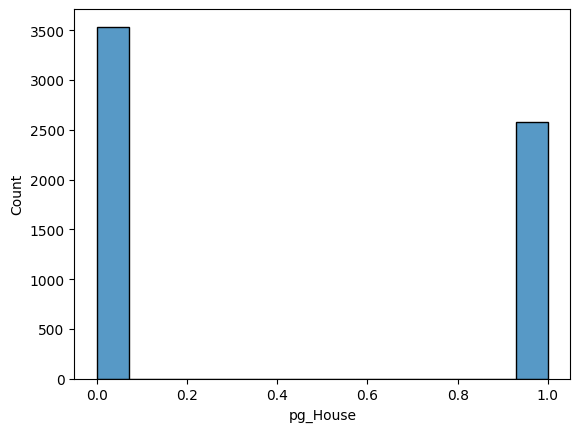

In [19]:
sns.histplot(db["pg_House"])

A little less than half the Airbnbs are houses.

<Axes: xlabel='pg_Townhouse', ylabel='Count'>

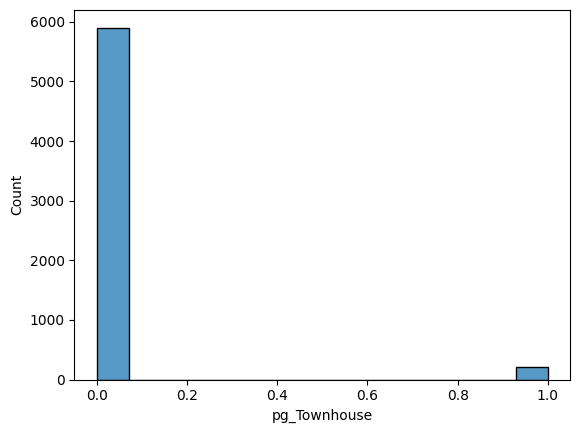

In [20]:
sns.histplot(db["pg_Townhouse"])

Also only a few Airbnbs are townhouses.

<Axes: xlabel='pg_Other', ylabel='Count'>

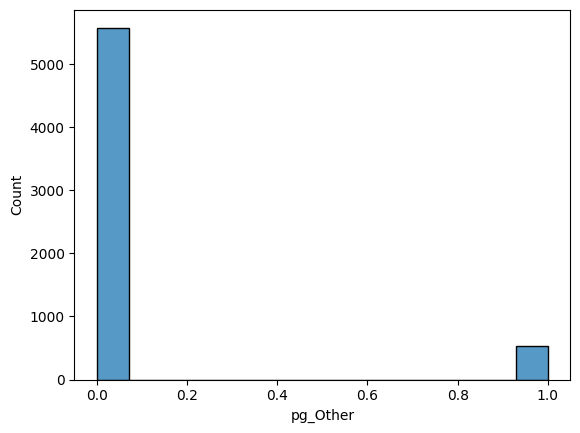

In [21]:
sns.histplot(db["pg_Other"])

The rest of the Airbnbs, which accumulate to around 10% are other kind of properties.

<Axes: xlabel='price', ylabel='Count'>

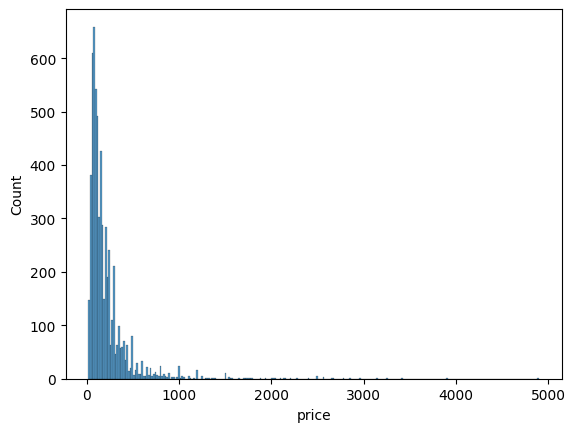

In [22]:
sns.histplot(db["price"])

Most Airbnbs are relativly low priced at below 500$ per night.

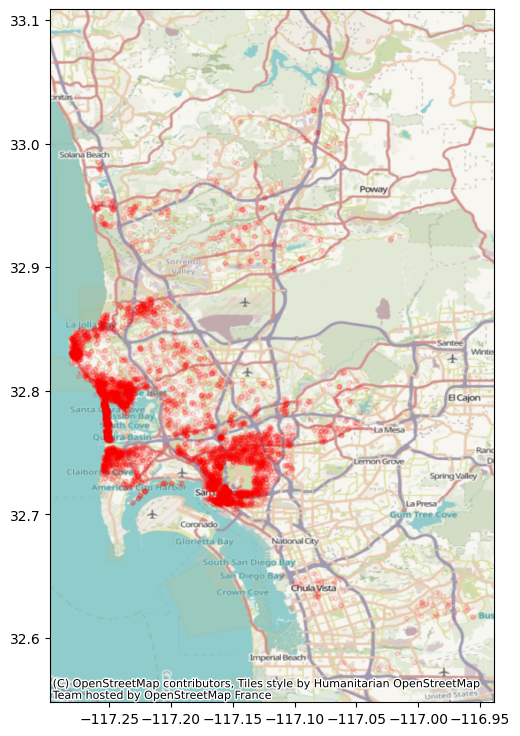

In [54]:
ax = db.plot(alpha=0.1, color="red", figsize=(9, 9), markersize=10)
cx.add_basemap(ax, crs=db.crs)

This map shows the density of the Airbnbs on top of a basemap of San Diego.

Prices arent included in this plot yet.

These are the variables you should analyze and later use to predict the `price`:

In [ ]:

variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

# PART 2 Feature Engineering: Get points-of-interest (POIs) and prepare them

Instructions:

* Use the method `features_from_address()` of osmnx to download POIs of the type `amenity` (select the types of amenities to include from this list here: https://wiki.openstreetmap.org/wiki/Key:amenity)
* Pay attention to set the `dist` parameter to an appropiate value 

In [ ]:
import osmnx as ox

In [ ]:
# Download the POI data <your code here> ...
pois = ""

In [ ]:
pois.head()

Data cleaning: The resulting `pois` geodataframe may have a composite row index. In addition, some POIs may be of a strange element_type. You can use the following code to eliminate these issues.

In [ ]:
# Clean the POI data
pois.reset_index(inplace=True) # reset the index of the data frame
pois = pois[pois.element_type=="node"] # eliminate all POIs that are not of the type "node"
pois.head() # check the results

Instructions:
* Plot the POIs spatially (use again a background map of San Diego)
* When you use POIs of different amenity types, color the POIs differently

In [ ]:
# <Your code here>

For each POI amenity type, create a kernel density estimation (KDE):
* Convert the `geometry` of the POI into a suitable coordinate data format (you may use the provided function `create_coordinate_array` for this)
* Feed the resulting coordinates into the `gaussian_kde` function and estimate the function
* Also convert the `geometry` of the Airbnb listings into the coordinate data format (you may use the provided function `create_coordinate_array` for this)
* Using the converted Airbnb geometries, compute the KDE for the locations of the Airbnb listings
* Add the KDE estimate as additional columns to your original airbnb geodataframe

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
# helper function to convert the geometries into a suitable coordinate format for the KDE
def create_coordinate_array(geometries): 
    x_values = []
    y_values = []

# Iterate through each row in the GeoDataFrame
    for multipoint in geometries:
        # Ensure the geometry is indeed MultiPoint; if it's just a single Point, wrap it in a list
        points = list(multipoint.geoms) if hasattr(multipoint, "geoms") else [multipoint]
        
        # For each Point in the MultiPoint, extract x and y values
        for point in points:
            x_values.append(point.x)
            y_values.append(point.y)

    # Optionally, convert the lists to numpy arrays for further processing
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    # Rearrange data to create a 2D array of x and y coordinates
    xy = np.vstack([x_values,y_values])

    return xy


# Example Usage for the Airbnb geodataframe
airbnb_array = create_coordinate_array(airbnb.geometry)

In [ ]:
#<Your code here>

Create a spatial point plot(s) of the Airbnb listings and color the points according to the KDE estimates, in order to check your results.

In [ ]:
# <your code here>

# PART 3: Modeling and Analysis (aka Machine Learning)

Use your dataset generated in the previous steps to predict AirBnb prices

Instructions:

* Split your data set into training and validation data sets
* Define an error metric (or several)
* Train at least one machine learning model (e.g. random forest) 
* Tune the hyperparameters (if applicable for the model)
* Evaluate the accuracy of the predicted prices against actual prices
* Compare the performance of the previous models when using different input data sets (benchmarks). Make sure to include the naive benchmark of predicting always the mean price.

In [ ]:
from sklearn.model_selection import train_test_split

X = ""
y = ""

## Model 1: Trivial Baseline

In [ ]:
# Trivial baseline: Predict always the mean price 
# <your code here>

## Model 2: ...

In [ ]:
# <your code here>

## Model 3: ...